In [9]:
import utils
from joblib import Parallel
from joblib import delayed
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import pandas
from datetime import datetime
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
datafile = 'preprocessed_data.csv'

# train_X = []
# train_y = []
# step = 3
# end = 2019 - step
# for year in range(2010, end):
#     X, y = utils.get_data(year, year + step, year + step, datafile)
#     train_X.append(X)
#     train_y.append(y)

# print(train_X)
# print(train_y)

# model = SARIMAX(train_X, order = (), seasonal_order = ())

def forecastSARIMA(history, hyperparams):
    order, seasonal, trend = hyperparams
    model = SARIMAX(history, order = order, seasonal_order = seasonal, trend = trend, enforce_stationarity = False, enforce_invertibility = False)
    model_fit = model.fit(disp = False)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def splitData(data, n):
    return data[:-n], data[-n:]

def validation(data, n, hyperparams):
    predictions = list()
    train, test = splitData(data, n)
    print(train)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = forecastSARIMA(history, hyperparams)
        predictions.append(yhat)
        history.append(test[i])
    err = mse(test, predictions)
    return err

def testModel(data, n, hyperparams):
    result = None
    key = str(hyperparams)
    result = validation(data, n, hyperparams)
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

def tuneHyperparams(data, hyperparams, n):
    scores = [testModel(data, n, param) for param in hyperparams]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def makeHyperparams(seasonal=[0]):
    models = list()
    p_params = [0,1,2]
    d_params = [0,1]
    q_params = [0,1,2]
    t_params = ['n','c','t','ct']
    P_params = [0,1,2]
    D_params = [0,1]
    Q_params = [0,1,2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    hyperparams = [(p,d,q), (P,D,Q,m), t]
                                    models.append(hyperparams)
    return models

if __name__ == '__main__':
    # Convert data to datetime
    data = pandas.read_csv(datafile)
    print(data)
    data["YEAR"] = data["YEAR"].astype(str) + " " + data["WEEK"].astype(str)
    for i in range(data.shape[0]):
        data.at[i, "YEAR"] = datetime.strptime(data.at[i, "YEAR"] + ' 0', "%Y %W %w")
    data = data.drop(columns=["WEEK", "REGION"])
    data = data.rename(columns={"YEAR": "TIME"})
    new_data = data.groupby(["TIME"])["TOTAL CASES"].sum()
    new_data.to_csv("arima_test.csv")
    new_data = pandas.read_csv("arima_test.csv", header=0, index_col=0)
    #values = new_data.loc(axis=0)["TIME"]
    print(new_data.values)
    print(new_data.shape)
    n = 52
    hyperparams = makeHyperparams(seasonal=[13,52])
    scores = tuneHyperparams(new_data.values, hyperparams, n)
    print('done')
    for hyperparams, error in scores[:3]:
        print(hyperparams, error)
        model = SARIMAX(new_data.values, order=hyperparams[0], seasonal_order=hyperparams[1])
        model_fit = model.fit()
        yhat = model_fit.forecast()

       Unnamed: 0          REGION  YEAR  WEEK  TOTAL CASES
0               0         Alabama  2010    40          0.0
1               1          Alaska  2010    40          0.0
2               2         Arizona  2010    40          1.0
3               3        Arkansas  2010    40          0.0
4               4      California  2010    40          6.0
...           ...             ...   ...   ...          ...
31045       17059       Wisconsin  2021    42          0.0
31046       17060         Wyoming  2021    42          0.0
31047       17061     Puerto Rico  2021    42          0.0
31048       17062  Virgin Islands  2021    42          0.0
31049       17063   New York City  2021    42          0.0

[31050 rows x 5 columns]
[[4.5000e+01]
 [6.7000e+01]
 [6.2000e+01]
 [8.8000e+01]
 [1.3400e+02]
 [1.8600e+02]
 [3.3100e+02]
 [3.9500e+02]
 [4.4800e+02]
 [7.3500e+02]
 [1.2350e+03]
 [1.7660e+03]
 [2.1310e+03]
 [2.3840e+03]
 [2.7390e+03]
 [3.4630e+03]
 [4.1910e+03]
 [4.5900e+03]
 [4.8050e+03]


KeyboardInterrupt: 

       Unnamed: 0          REGION  YEAR  WEEK  TOTAL CASES
0               0         Alabama  2010    40          0.0
1               1          Alaska  2010    40          0.0
2               2         Arizona  2010    40          1.0
3               3        Arkansas  2010    40          0.0
4               4      California  2010    40          6.0
...           ...             ...   ...   ...          ...
31045       17059       Wisconsin  2021    42          0.0
31046       17060         Wyoming  2021    42          0.0
31047       17061     Puerto Rico  2021    42          0.0
31048       17062  Virgin Islands  2021    42          0.0
31049       17063   New York City  2021    42          0.0

[31050 rows x 5 columns]
(575, 1)
45.0
done
[(0, 0, 0), (2, 1, 2, 52), 'c']
52


/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/s

[334.02133522]
MSE: 33490267.47354329
[(0, 0, 0), (2, 1, 2, 13), 'c']
52


/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/s

[1385.91465242]
MSE: 41809116.146582276
[(0, 0, 0), (2, 1, 1, 13), 'c']
52


/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amypaul/opt/anaconda3/lib/python3.8/s

[2462.87287599]
MSE: 32729529.283418152


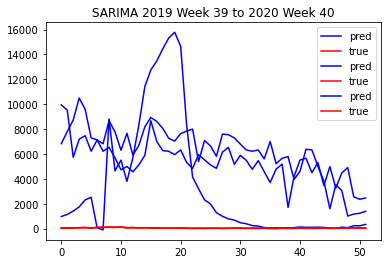

In [16]:
import utils
from joblib import Parallel
from joblib import delayed
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import pandas
from datetime import datetime
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
datafile = 'preprocessed_data.csv'

def forecastSARIMA(history, hyperparams):
    #print(history)
    order, seasonal, trend = hyperparams
    model = SARIMAX(history, order = order, seasonal_order = seasonal, trend = trend, enforce_stationarity = False, enforce_invertibility = False)
    model_fit = model.fit(disp = True)
    yhat = model_fit.predict(len(history), len(history))
    #print(model_fit)
    return yhat

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def splitData(data, n):
    return data[:-n], data[-n:]

def validation(data, n, hyperparams):
    predictions = list()
    train, test = splitData(data, n)
    print(train)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = forecastSARIMA(history, hyperparams)
        predictions.append(yhat)
        history.append(test[i])
    err = mse(test, predictions)
    return err

def testModel(data, n, hyperparams):
    result = None
    key = str(hyperparams)
    result = validation(data, n, hyperparams)
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

def tuneHyperparams(data, hyperparams, n):
    scores = [testModel(data, n, param) for param in hyperparams]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def makeHyperparams(seasonal=[0]):
    models = list()
    p_params = [0,1,2]
    d_params = [0,1]
    q_params = [0,1,2]
    t_params = ['n','c','t','ct']
    P_params = [0,1,2]
    D_params = [0,1]
    Q_params = [0,1,2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    hyperparams = [(p,d,q), (P,D,Q,m), t]
                                    models.append(hyperparams)
    return models

if __name__ == '__main__':
    # Convert data to datetime
    data = pandas.read_csv(datafile)
    print(data)
    data["YEAR"] = data["YEAR"].astype(str) + " " + data["WEEK"].astype(str)
    for i in range(data.shape[0]):
        data.at[i, "YEAR"] = datetime.strptime(data.at[i, "YEAR"] + ' 0', "%Y %W %w")
    data = data.drop(columns=["WEEK", "REGION"])
    data = data.rename(columns={"YEAR": "TIME"})
    new_data = data.groupby(["TIME"])["TOTAL CASES"].sum()
    new_data.to_csv("arima_test.csv")
    new_data = pandas.read_csv("arima_test.csv", header=0, index_col=0)
    #values = new_data.loc(axis=0)["TIME"]
    #print(new_data.values)
    print(new_data.shape)
    print(new_data["TOTAL CASES"][0])
    n = 52
    #hyperparams = makeHyperparams(seasonal=[13,52])
    #scores = tuneHyperparams(new_data.values, hyperparams, n)
    scores = [[(0, 0, 0), (2, 1, 2, 52), 'c'], [(0, 0, 0), (2, 1, 2, 13), 'c'], [(0, 0, 0), (2, 1, 1, 13), 'c']]
    print('done')
    for hyperparams in scores[:3]:
        print(hyperparams)
        #model = SARIMAX(new_data.values, order=hyperparams[0], seasonal_order=hyperparams[1])
        predictions = list()
        train, test = splitData(new_data.values, n)
        print(len(test))
        history = [x for x in train]
        for i in range(len(test)):
            yhat = forecastSARIMA(history, hyperparams)
            predictions.append(yhat)
            history.append(test[i])
        weeks = [i for i in range(52)]
        print(yhat)
        print(f"MSE: {mean_squared_error(predictions, test)}")
        # compare test_y and pred_y
        plt.plot(weeks, predictions, label="pred", color="blue")
        plt.plot(weeks, test, label="true", color="red")
        plt.title(f"SARIMA 2019 Week 39 to 2020 Week 40")
        plt.legend()
